In [1]:
from nba_api.stats.static import players
from nba_api.stats.endpoints import playergamelog
from nba_api.stats.library.parameters import SeasonAll
import pandas as pd


In [4]:
# Get a list of all active NBA players
player_dict = players.get_active_players()

seasons = [f"{year}-{str(year+1)[-2:]}" for year in range(2015, 2022)]

total_seasons = len(seasons)

# Store the top 10 shooters for each season
season_top_shooters = {}

for i, season in enumerate(seasons):
    season_3pt_shooters = []

    for player in player_dict:
        player_id = player['id']
        player_name = f"{player['first_name']} {player['last_name']}"

        try:
            # Get game log for the player for the specific season
            game_log = playergamelog.PlayerGameLog(player_id=player_id, season=season)
            game_log_df = game_log.get_data_frames()[0]

            # Calculate the total 3-point attempts and makes
            total_3pa = game_log_df['FG3A'].sum()
            total_3pm = game_log_df['FG3M'].sum()

            # Check if the player has at least 100 3PA
            if total_3pa >= 100:
                efficiency_3pm = total_3pm / total_3pa
                season_3pt_shooters.append({'Player': player_name, '3PT Efficiency': efficiency_3pm, '3PA': total_3pa})

        except Exception as e:
            print(f"Error processing player {player_name} for season {season}: {str(e)}")

    # Sort the players by their three-point shooting efficiency and get the top 10
    season_top_shooters[season] = sorted(season_3pt_shooters, key=lambda x: x['3PT Efficiency'], reverse=True)[:10]

    # Print the progress
    print(f"Processed {i+1} out of {total_seasons} seasons. ({(i+1)/total_seasons*100:.2f}%)")

# Print the top 10 shooters for each season
print("\nTop 10 Three-Point Shooters by Efficiency per Season (min 100 attempts):")
for season, shooters in season_top_shooters.items():
    print(f"\n{season}:")
    for rank, shooter in enumerate(shooters, start=1):
        print(f"{rank}. {shooter['Player']} - {shooter['3PT Efficiency']:.3f} (3PA: {shooter['3PA']})")

Processed 1 out of 7 seasons. (14.29%)
Processed 2 out of 7 seasons. (28.57%)
Processed 3 out of 7 seasons. (42.86%)
Processed 4 out of 7 seasons. (57.14%)
Processed 5 out of 7 seasons. (71.43%)
Processed 6 out of 7 seasons. (85.71%)
Processed 7 out of 7 seasons. (100.00%)

Top 10 Three-Point Shooters by Efficiency per Season (min 100 attempts):

2015-16:
1. Josh Richardson - 0.461 (3PA: 115)
2. Stephen Curry - 0.454 (3PA: 886)
3. Seth Curry - 0.450 (3PA: 111)
4. Kawhi Leonard - 0.443 (3PA: 291)
5. Doug McDermott - 0.425 (3PA: 259)
6. Klay Thompson - 0.425 (3PA: 650)
7. CJ McCollum - 0.417 (3PA: 472)
8. Kelly Olynyk - 0.405 (3PA: 210)
9. Patrick Beverley - 0.400 (3PA: 310)
10. Evan Fournier - 0.400 (3PA: 390)

2016-17:
1. Joe Ingles - 0.441 (3PA: 279)
2. Otto Porter Jr. - 0.434 (3PA: 341)
3. Khris Middleton - 0.433 (3PA: 104)
4. Seth Curry - 0.425 (3PA: 322)
5. CJ McCollum - 0.421 (3PA: 439)
6. Gary Harris - 0.420 (3PA: 255)
7. Mike Muscala - 0.418 (3PA: 110)
8. Klay Thompson - 0.414 (

In [2]:
import random
from sklearn.linear_model import LinearRegression
from nba_api.stats.endpoints import playercareerstats, commonplayerinfo

def get_player_height(player_id):
    # Get player info
    player_info = commonplayerinfo.CommonPlayerInfo(player_id=player_id)
    player_info = player_info.get_normalized_dict()
    player_info = player_info.get('CommonPlayerInfo')[0]

    # Return player height
    return player_info.get('HEIGHT')

# Sample code to fetch player height and 3-point percentage

player_dict = players.get_active_players()
player_data = []

for player in player_dict:
    player_id = player['id']
    player_name = player['full_name']

    # Fetch career stats for the player
    career = playercareerstats.PlayerCareerStats(player_id=player_id)
    career_df = career.get_data_frames()[0]

    # Calculate career 3-point percentage
    total_3pa = career_df['FG3A'].sum()
    total_3pm = career_df['FG3M'].sum()
    three_pt_pct = total_3pm / total_3pa if total_3pa > 0 else None

    # Get player height
    height = get_player_height(player_id)

    if height is not None and three_pt_pct is not None:
        player_data.append({'Player': player_name, 'Height': height, '3PT%': three_pt_pct})

# Create a DataFrame
df = pd.DataFrame(player_data)

# Data preprocessing steps (e.g., converting height to a numerical value) go here
def height_to_inches(height_str):
    feet, inches = height_str.split('-')
    return int(feet) * 12 + int(inches)

# Convert height to inches in the DataFrame
df['Height'] = df['Height'].apply(height_to_inches)

# Drop rows with missing values
df.dropna(inplace=True)

# Create a linear regression model
X = df[['Height']]
y = df['3PT%']
model = LinearRegression().fit(X, y)

# Output the coefficient and R-squared value
print('Coefficient:', model.coef_)
print('R-squared:', model.score(X, y))

Coefficient: [-0.00856265]
R-squared: 0.06243063825186668


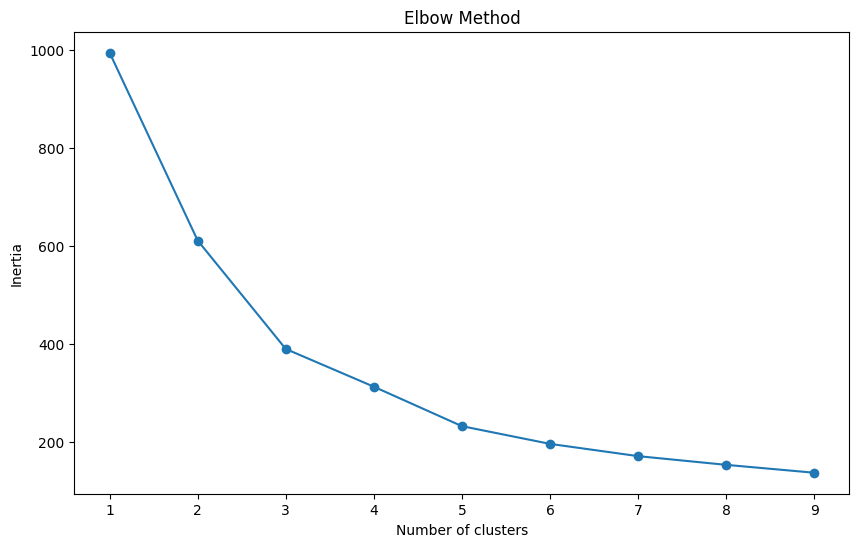


Cluster 0:
Average Height: 74.65384615384616
Average 3PT%: 0.34544323199544347

Cluster 1:
Average Height: 78.38207547169812
Average 3PT%: 0.3528981149686523

Cluster 2:
Average Height: 80.27272727272727
Average 3PT%: 0.06653092676324991

Cluster 3:
Average Height: 82.41121495327103
Average 3PT%: 0.320901977000925

Cluster 4:
Average Height: 75.5
Average 3PT%: 0.8333333333333333


In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Function to convert height from 'feet-inches' to inches
# Fetching player height and 3-point percentage
player_dict = players.get_active_players()
player_data = []

for player in player_dict:
    player_id = player['id']
    player_name = player['full_name']

    career = playercareerstats.PlayerCareerStats(player_id=player_id)
    career_df = career.get_data_frames()[0]

    total_3pa = career_df['FG3A'].sum()
    total_3pm = career_df['FG3M'].sum()
    three_pt_pct = total_3pm / total_3pa if total_3pa > 0 else None

    height = get_player_height(player_id)

    if height is not None and three_pt_pct is not None:
        player_data.append({'Player': player_name, 'Height': height, '3PT%': three_pt_pct})

df = pd.DataFrame(player_data)
df['Height'] = df['Height'].apply(height_to_inches)
df.dropna(inplace=True)

# Normalize the features
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[['Height', '3PT%']])

# Determine the optimal number of clusters (Elbow Method)
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 10), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

# Choose a number of clusters based on the Elbow plot (e.g., 3)
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
clusters = kmeans.fit_predict(df_scaled)

# Add cluster information to the DataFrame
df['Cluster'] = clusters

# Analyze the clusters
for i in range(n_clusters):
    cluster_data = df[df['Cluster'] == i]
    print(f"\nCluster {i}:")
    print(f"Average Height: {cluster_data['Height'].mean()}")
    print(f"Average 3PT%: {cluster_data['3PT%'].mean()}")